In [101]:
import numpy as np
import control
from control.matlab import *
import matplotlib.pyplot as plt

In [102]:
num = [1.076]
den = [1.027, 3.141, 1.939]
G = tf(num,den)

In [103]:
ts = 1e-2
T = 900
t = np.arange(0, T, ts)
u = np.random.normal(0, 100, t.shape)

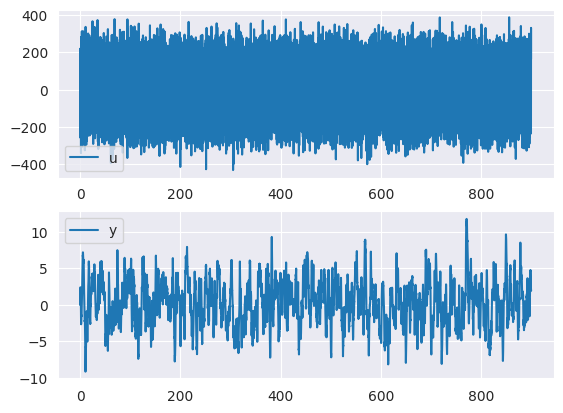

In [104]:
y, t, _ = lsim(G, u, t)
plt.subplot(211)
plt.plot(t, u, label="u")
plt.legend()
plt.subplot(212)
plt.plot(t, y, label="y")
plt.legend()

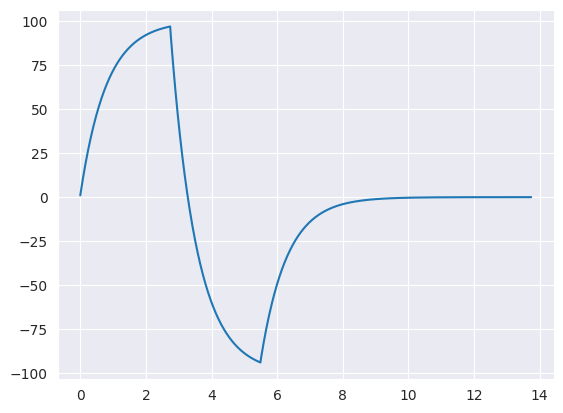

In [105]:
# reference

# VRFT
s = tf('s')
tau = 5 # s
M = 1/(1 + (tau/(2*np.pi))*s)
M = M*(1 + 1e-2*(tau/(2*np.pi))*s) # add a high freq zero for inversion
T_cl = tau + 0.5
t_cl = np.arange(0, 2.5*T_cl, ts)

r = np.zeros(t_cl.shape)
r[t_cl < T_cl/2] = 100
r[(t_cl >= T_cl/2) & (t_cl < T_cl)] = -100

y_d = lsim(M,r, t_cl)[0]
plt.plot(t_cl, y_d)

In [106]:
r_v = lsim(M**(-1), y, t)[0]
e_v = r_v - y

In [107]:
B = [tf([1], [1], dt=ts),
     tf(ts * np.array([1, 1]), 2 * np.array([1, -1]), dt=ts),
     tf(np.array([2, -2]), ts * np.array([3, -1]), dt=ts)]

import cvxpy as cp

theta = cp.Variable(3)
#u_theta = theta[0]*lsim(B[0], e_v, t)[0] + theta[1]*lsim(B[1], e_v, t)[0] 
u_theta = theta[0] * lsim(B[0], e_v, t)[0] + theta[1] * lsim(B[1], e_v, t)[0] + theta[2] * lsim(B[2], e_v, t)[0]
cost = cp.sum_squares(u - u_theta)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()
theta_sol = theta.value
print(theta_sol)

[0.20603529 0.72730124 0.3808854 ]


In [108]:
C = theta_sol[0]*B[0] + theta_sol[1]*B[1] + theta_sol[2]*B[2]

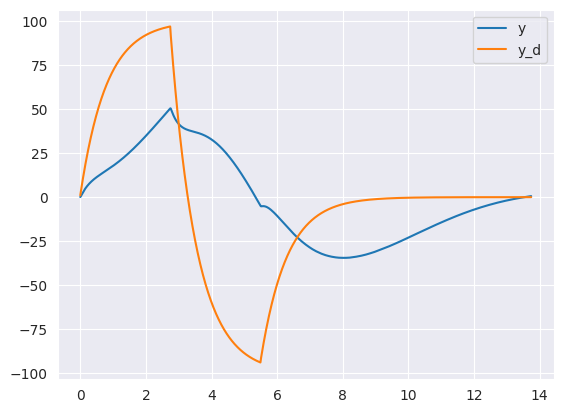

In [109]:
G = c2d(G, ts, 'tustin')
F = C*G/(1 + C*G)
y_cl = lsim(F,r,t_cl)[0]
plt.plot(t_cl, y_cl, label='y')
plt.plot(t_cl, y_d, label='y_d')
plt.legend()
plt.show()

In [110]:
err = y_cl - y_d
## CALCULATE MSE (r, y) 
error_tot = 0
for k in range(len(err)):
    squared_error = err[k] * err[k]
    error_tot += squared_error 
MSE = error_tot / len(err)
print(f"MSE: {MSE:.5f}")

# relative error, in percentage
absolute_difference = np.abs(err)
sum_abs_diff = np.sum(absolute_difference)
sum_abs_actual = np.sum(np.abs(r))

re = (sum_abs_diff / sum_abs_actual) * 100

print(f"Relative Error: {re:.2f}%")

MSE: 2208.36707
Relative Error: 90.83%
